In [1]:
# %pip install gdown

In [1]:
# %pip list

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
from tqdm.notebook import tqdm
from dataclasses import dataclass

import safetensors
import pathlib
import os 
import matplotlib.pyplot as plt


libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [2]:
device = 'cuda:0'

@dataclass
class config:
    # training params
    is_train_run = False
    n_epochs = 5
    # image params
    image_size = 256
    # dataset params
    batch_size = 64
    # model params
    dict_dim_scaler = 20
    # optim params
    lr = 1e-3
    weight_decay = 0
    n_gradient_accumulation_steps = 1
    max_grad_norm = 1.0
    # logging
    log_every_n_grad_steps = 512
    tqdm_print_every_n_grad_steps = 512*10

In [3]:
# import time
# time.sleep(60 * 10)

# Load data

In [4]:
os.listdir()

['diffusion-dict-learn',
 'data',
 '.ipynb_checkpoints',
 'lsun',
 'train-sae.ipynb',
 'sae_checkpoints']

In [5]:
# # # Do not use LSUN original
# # Unzip LSUN
# import shutil 
# shutil.unpack_archive(filename='data/lsun/bedroom_train_lmdb.zip', extract_dir='data/lsun', format='zip')

In [6]:
# from datasets import load_dataset

# ds = load_dataset("pcuenq/lsun-bedrooms")
# ds.keys()

In [7]:
# ds

In [8]:
# The script below did not print anything, thus the images are at least 256 in 1 dim
# for img_iter in tqdm(ds['train']):
#     size_img = img_iter['image'].size
    
#     if min(size_img) < 256:
#         print('Smaller than 256')

In [9]:
# # convert to png images

# import torchvision.transforms as T

# # transforms_save = None
# transforms_save = T.CenterCrop(size=config.image_size)

# n_max_images_to_save = 20_000
    
# for subset_str in ['train', 'test']:
#     dir_bigger_ds = pathlib.Path(f'data/bedroom_nolabels/{subset_str}')
#     dir_bigger_ds.mkdir(exist_ok=True)

#     for i, img_iter in tqdm(enumerate(ds[subset_str]), total=len(ds[subset_str])):
#         img_iter = img_iter['image']
#         if transforms_save is not None:
#             img_iter = transforms_save(img_iter)
#         filename_save = f"bedroom_unsup_{i:05d}.png"
#         img_iter.save(dir_bigger_ds / filename_save)
        
#         if i > n_max_images_to_save:
#             break
#         # plt.imshow(img_iter)
#         # plt.show()

In [10]:
# # Donwload the sample dataset 
# import gdown
# url = 'https://drive.google.com/file/d/1-RQzMIX4yzOYcHRnc-5K6B98eR2dypz6/view?usp=sharing'
# output = 'data/'
# gdown.download(url, output, quiet=False, fuzzy=True)

In [11]:
# path_data = pathlib.Path("data/clf_features_20_50.safetensors")
# data = safetensors.safe_open(path_data, framework='pt')
# X, y = data.get_tensor('x_50'), data.get_tensor('y')
# print(X.shape, y.shape)
# print(f'Unique vals in y: {y.unique()}')

if config.is_train_run:
    # path_data = pathlib.Path("diffusion-dict-learn/sae_features_train_1000.safetensors")
    path_data = pathlib.Path("diffusion-dict-learn/sae_features_train_20k.safetensors")
    data = safetensors.safe_open(path_data, framework='pt')
    X = data.get_tensor('250_6')
    print(X.shape)
    X = X.permute(0,2,3,1).reshape(-1, 512)
    print(X.shape)


    test_ratio = 0.01
    split_id_train = int(len(X) * (1-test_ratio))

    X_train, X_eval = X[:split_id_train], X[split_id_train:]
    # y_train, y_eval = y[:split_id_train], y[split_id_train:]

    train_loader = DataLoader(
        dataset=X_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=False,
        drop_last=True
    )
    eval_loader = DataLoader(
        dataset=X_eval, 
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False
    )

# What the '0' is for - the one that is dropped in the LESS paper when acquiring 2D maps

In [12]:
# files_img_dataset = 'diffusion-dict-learn/datasets/bedroom_28/real/train'
# uniques_filename = list(set([name_.split('.')[0] for name_ in os.listdir(files_img_dataset) if name_.endswith('png')]))

# num_iter = 3
# i_delta = 0
# for filename in uniques_filename[:num_iter]:
#     file_mask = pathlib.Path(files_img_dataset) / f"{filename}.npy"
#     img_mask = np.load(file_mask)    
#     file_png = pathlib.Path(files_img_dataset) / f"{filename}.png"
#     img_png = plt.imread(file_png)

#     # Unique classes on the mask
#     print(np.unique(img_mask))

#     f, axs = plt.subplots(1,3, figsize=(8,2))
#     axs[0].imshow(img_png)
#     axs[1].imshow(img_mask)
#     axs[2].imshow(img_mask==0)
#     # plt.axes(False)
#     plt.show()

> 0 label seems to be reserved for others

# SAE training

Starting with more vanilla SAE w/o top-k or JumpRelu

> Taken from https://github.com/ApolloResearch/e2e_sae/blob/main/e2e_sae/models/sparsifiers.py

In [13]:
import torch
import torch.nn.functional as F
from torch import nn

class SAE(nn.Module):
    """
    Sparse AutoEncoder
    """

    def __init__(
        self, input_size: int, n_dict_components: int, init_decoder_orthogonal: bool = True
    ):
        """Initialize the SAE.

        Args:
            input_size: Dimensionality of input data
            n_dict_components: Number of dictionary components
            init_decoder_orthogonal: Initialize the decoder weights to be orthonormal
        """

        super().__init__()
        # self.encoder[0].weight has shape: (n_dict_components, input_size)
        # self.decoder.weight has shape:    (input_size, n_dict_components)

        self.encoder = nn.Sequential(nn.Linear(input_size, n_dict_components, bias=True), nn.ReLU())
        self.decoder = nn.Linear(n_dict_components, input_size, bias=True)
        self.n_dict_components = n_dict_components
        self.input_size = input_size

        if init_decoder_orthogonal:
            # Initialize so that there are n_dict_components orthonormal vectors
            self.decoder.weight.data = nn.init.orthogonal_(self.decoder.weight.data.T).T

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Pass input through the encoder and normalized decoder."""
        h = self.encoder(x)
        x_hat = F.linear(h, self.dict_elements, bias=self.decoder.bias)
        return x_hat, h

    @property
    def dict_elements(self):
        """Dictionary elements are simply the normalized decoder weights."""
        return F.normalize(self.decoder.weight, dim=0)

    @property
    def device(self):
        return next(self.parameters()).device

## Loss

In [15]:
class SparsityLoss():
    def __init__(self):
        self.p_norm: float = 1.0

    def calc_loss(self, h, dense_dim: int):
        """Calculate the sparsity loss.
        Note that we divide by the dimension of the input to the SAE. This helps with using the same
        hyperparameters across different model sizes (input dimension is more relevant than the c
        dimension for Lp loss).
        Args:
            h: The activations after the non-linearity in the SAE.
            dense_dim: The dimension of the input to the SAE. Used to normalize the loss.
        Returns:
            The L_p norm of the activations.
        """
        return torch.norm(h, p=self.p_norm, dim=-1).mean() / dense_dim
    
class ReconstructionLoss():
    def __init__(self):
        pass
    
    def calc_loss(
        self, z, z_hat
    ):
        """Calculate the MSE between the input and orig."""
        return F.mse_loss(z, z_hat)
    
class SAELoss():
    def __init__(self, coef_sparse):
        self.rec_loss = ReconstructionLoss()
        self.sparse_loss = SparsityLoss()
        self.coef_sparse = coef_sparse
        
    def calc_loss(
        self, z, z_hat, h
    ):
        """
        Calculate the loss (Sparsity+Reconstr*corf).
            Sparsity on `h`
            Reconstruction b/w z and z_hat
        """
        dense_dim = z.size(-1)
        
        loss_rec = self.rec_loss.calc_loss(z, z_hat)
        loss_sparse = self.sparse_loss.calc_loss(h, dense_dim=dense_dim)
        loss_val = loss_rec + self.coef_sparse*loss_sparse
        
        dict_loss_info = {'rec': loss_rec.detach().cpu().item(), 'sparse': loss_sparse.detach().cpu().item(), 'coef_sparse': self.coef_sparse}
        return loss_val, dict_loss_info

### Train loop

In [18]:
dense_dim = 512


sae_loss = SAELoss(coef_sparse=0.001)
model = SAE(input_size=dense_dim, n_dict_components=dense_dim*config.dict_dim_scaler).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = None

# logging 
dict_logs = {}

total_samples = 0
grad_updates = 0
# samples_since_act_frequency_collection = 0

dir_model = pathlib.Path('sae_checkpoints')
dir_model.mkdir(exist_ok=True)
filename_model = f"sae-x{config.dict_dim_scaler}-n_ep{config.n_epochs}"

if config.is_train_run:
    n_batches = len(train_loader)
    for epoch in range(config.n_epochs):
        filename_model_iter = filename_model + f"-ep{epoch}"
        for batch_idx, batch in tqdm(enumerate(train_loader), total=n_batches, desc="Steps"):
            # dense_embs [bs, dense_dim]
            # dense_dim = 512 in LESS paper
            dense_embs = batch.to(device=device)

            total_samples = total_samples + dense_embs.shape[0]
            # samples_since_act_frequency_collection += dense_embs.shape[0]

            is_grad_step: bool = (batch_idx + 1) % config.n_gradient_accumulation_steps == 0

            # # Note that is_last_batch will always be False for iterable datasets with n_samples=None. In
            # # that case, we will never know when the final batch is reached.
            # is_last_batch: bool = n_batches is not None and batch_idx == n_batches - 1
            # is_eval_step: bool = config.eval_every_n_samples is not None and (
            #     (batch_idx == 0)
            #     or total_samples - total_samples_at_last_eval >= config.eval_every_n_samples
            #     or is_last_batch
            # )
            # is_collect_act_frequency_step: bool = config.collect_act_frequency_every_n_samples > 0 and (
            #     batch_idx == 0
            #     or (
            #         samples_since_act_frequency_collection
            #         >= config.collect_act_frequency_every_n_samples
            #     )
            # )
            is_log_step: bool = (
                batch_idx == 0
                or (is_grad_step and (grad_updates + 1) % config.log_every_n_grad_steps == 0)
                # or is_eval_step
                # or is_last_batch
            )
            # is_save_model_step: bool = save_dir is not None and (
            #     (
            #         config.save_every_n_samples
            #         and total_samples - total_samples_at_last_save >= config.save_every_n_samples
            #     )
            #     or is_last_batch
            # )

            x_hat, h = model(dense_embs)

            loss, dict_loss_info = sae_loss.calc_loss(dense_embs, x_hat, h)

            loss = loss / config.n_gradient_accumulation_steps
            loss.backward()

            if is_grad_step:
                if config.max_grad_norm is not None:
                    grad_norm = torch.nn.utils.clip_grad_norm_(
                        model.parameters(), config.max_grad_norm
                    ).item()
                optimizer.step()
                optimizer.zero_grad()
                grad_updates += 1
                if scheduler is not None:
                    scheduler.step()

        #     if is_collect_act_frequency_step and act_frequency_metrics is None:
        #         # Start collecting activation frequency metrics for next config.act_frequency_n_tokens
        #         act_frequency_metrics = ActFrequencyMetrics(
        #             dict_sizes={
        #                 hook_pos: new_act_pos.c.shape[-1]
        #                 for hook_pos, new_act_pos in new_acts.items()
        #                 if isinstance(new_act_pos, SAEActs)
        #             },
        #             device=device,
        #         )
        #         samples_since_act_frequency_collection = 0

        #     if act_frequency_metrics is not None:
        #         act_frequency_metrics.update_dict_el_frequencies(
        #             new_acts, batch_tokens=tokens.shape[0] * tokens.shape[1]
        #         )
        #         if act_frequency_metrics.tokens_used >= config.act_frequency_n_tokens:
        #             # Finished collecting activation frequency metrics
        #             metrics = act_frequency_metrics.collect_for_logging(
        #                 log_wandb_histogram=config.wandb_project is not None
        #             )
        #             metrics["total_tokens"] = total_tokens
        #             if config.wandb_project:
        #                 # TODO: Log when not using wandb too
        #                 wandb.log(metrics, step=total_samples)
        #             act_frequency_metrics = None
        #             samples_since_act_frequency_collection = 0

            if is_log_step:
                if (grad_updates + 1) % config.tqdm_print_every_n_grad_steps == 0:
                    tqdm.write(
                        f"Samples {total_samples:08d} Batch_idx {batch_idx:06d} GradUpdates {grad_updates:06d} "
                        f"MSE:{dict_loss_info['rec']/config.n_gradient_accumulation_steps:.5f}, "
                        f"Sparsity:{dict_loss_info['sparse']*dict_loss_info['coef_sparse']/config.n_gradient_accumulation_steps:.5f}"
                    )

                for k, v in dict_loss_info.items():
                    if k not in dict_logs:
                        dict_logs[k] = []
                    dict_logs[k].append(v)
        #         if config.wandb_project:
        #             log_info = {
        #                 "loss": loss.item(),
        #                 "grad_updates": grad_updates,
        #                 "total_tokens": total_tokens,
        #                 "lr": optimizer.param_groups[0]["lr"],
        #             }
        #             log_info.update({k: v.item() for k, v in loss_dict.items()})
        #             if grad_norm is not None:
        #                 log_info["grad_norm"] = grad_norm  # Norm of grad before clipping

        #             sparsity_metrics = calc_sparsity_metrics(new_acts=new_acts)
        #             log_info.update(sparsity_metrics)

        #             if new_logits is not None:
        #                 train_output_metrics = calc_output_metrics(
        #                     tokens=tokens,
        #                     orig_logits=orig_logits.detach().clone(),
        #                     new_logits=new_logits.detach().clone(),
        #                 )
        #                 log_info.update(train_output_metrics)

        #             if is_eval_step:
        #                 eval_metrics = evaluate(
        #                     config=config, model=model, device=device, cache_positions=cache_positions
        #                 )
        #                 total_samples_at_last_eval = total_samples
        #                 log_info.update(eval_metrics)

        #             wandb.log(log_info, step=total_samples)

        #     if is_save_model_step:
        #         assert save_dir is not None
        #         total_samples_at_last_save = total_samples
        #         save_module(
        #             config_dict=config.model_dump(mode="json"),
        #             save_dir=save_dir,
        #             module=model.saes,
        #             model_filename=f"samples_{total_samples}.pt",
        #             config_filename="final_config.yaml",
        #         )
        #         if config.wandb_project:
        #             wandb.save(
        #                 str(save_dir / f"samples_{total_samples}.pt"), policy="now", base_path=save_dir
        #             )

            # if is_last_batch:
            #     break
        torch.save(model.state_dict(), dir_model/(filename_model_iter + ".ckpt"))


In [20]:
if config.is_train_run:
    rec_loss_list = dict_logs['rec']
    sparse_loss_list = dict_logs['sparse']

    fig, ax1 = plt.subplots(figsize=(16,5))

    color = 'tab:red'
    ax1.set_xlabel('x axis')
    ax1.set_ylabel('MSE', color=color)
    ax1.plot(rec_loss_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_yscale('log')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('L1 latents', color=color)  # we already handled the x-label with ax1
    ax2.plot(sparse_loss_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    # ax2.set_yscale('log')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [21]:
if config.is_train_run:
    # Save model
    torch.save(model.state_dict(), dir_model/(filename_model+"-last"+".ckpt"))

# Load model
model.load_state_dict(torch.load(dir_model/filename_model+"-last"+".ckpt"))

/tmp/ipykernel_210425/2671914751.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(dir_model/filename_model))


<All keys matched successfully>

# Match latent activations and GT masks

In [22]:
# path_data = pathlib.Path("data/clf_features_20_50.safetensors")
# data = safetensors.safe_open(path_data, framework='pt')
# X, y = data.get_tensor('x_50'), data.get_tensor('y')
# print(X.shape, y.shape)
# print(f'Unique vals in y: {y.unique()}')

# path_data = pathlib.Path("diffusion-dict-learn/sae_features_train_1000.safetensors")
path_data = pathlib.Path("diffusion-dict-learn/sae_features_labeled_20.safetensors")
data = safetensors.safe_open(path_data, framework='pt')
X_eval = data.get_tensor('250_6')
# print(X_eval.shape)
# X_eval = X_eval.permute(0,2,3,1)
print(X_eval.shape)

torch.Size([20, 512, 32, 32])


Load masks - y

[ 0  1  2  3  4  6  8 10 11 12 14 15 16 23 27 28]


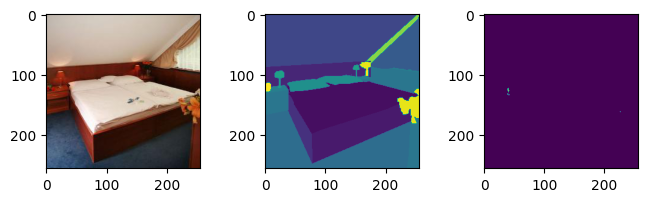

[ 1  5  6 11 12 17 18 19 20 21 23]


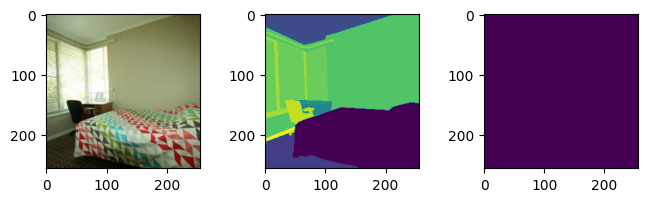

[ 0  1  5  6  8 10 11 13 14 17 18 19 20 21 22 23 28]


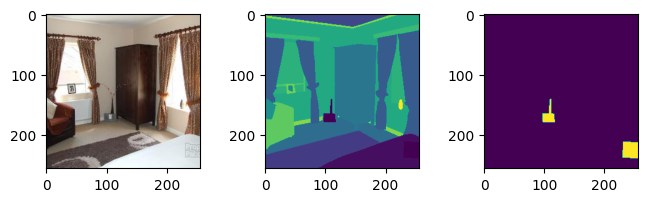

In [23]:
files_img_dataset = 'diffusion-dict-learn/datasets/bedroom_28/real/test'
uniques_filename = list(set([name_.split('.')[0] for name_ in os.listdir(files_img_dataset) if name_.endswith('png')]))

num_iter = 3
i_delta = 0
for filename in uniques_filename[:num_iter]:
    file_mask = pathlib.Path(files_img_dataset) / f"{filename}.npy"
    img_mask = np.load(file_mask)    
    file_png = pathlib.Path(files_img_dataset) / f"{filename}.png"
    img_png = plt.imread(file_png)

    # Unique classes on the mask
    print(np.unique(img_mask))

    f, axs = plt.subplots(1,3, figsize=(8,2))
    axs[0].imshow(img_png)
    axs[1].imshow(img_mask)
    axs[2].imshow(img_mask==0)
    # plt.axes(False)
    plt.show()

In [145]:
y_eval= []
imgs_eval = []
for filename in tqdm(sorted(uniques_filename)):
    file_mask = pathlib.Path(files_img_dataset) / f"{filename}.npy"
    img_mask = np.load(file_mask)    
    file_png = pathlib.Path(files_img_dataset) / f"{filename}.png"
    img_png = plt.imread(file_png)

    y_eval.append(img_mask)
    imgs_eval.append(img_png)

y_eval = np.stack(y_eval)    
imgs_eval = np.stack(imgs_eval)    

print(y_eval.shape, imgs_eval.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

(20, 256, 256) (20, 256, 256, 3)


In [146]:
model.eval()

# Interpolate to the img size, flatten and pass 

latents_list = []
with torch.no_grad():
    for idx, sample in tqdm(enumerate(X_eval), total=len(X_eval), desc="Steps"):
        dense_embs = F.interpolate(
            sample.unsqueeze(0), size=config.image_size, mode='bilinear',
        )[0].permute(1,2,0)
        x_hat, h = model(dense_embs.to(device))
        latents_list.append(h.detach().cpu())

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

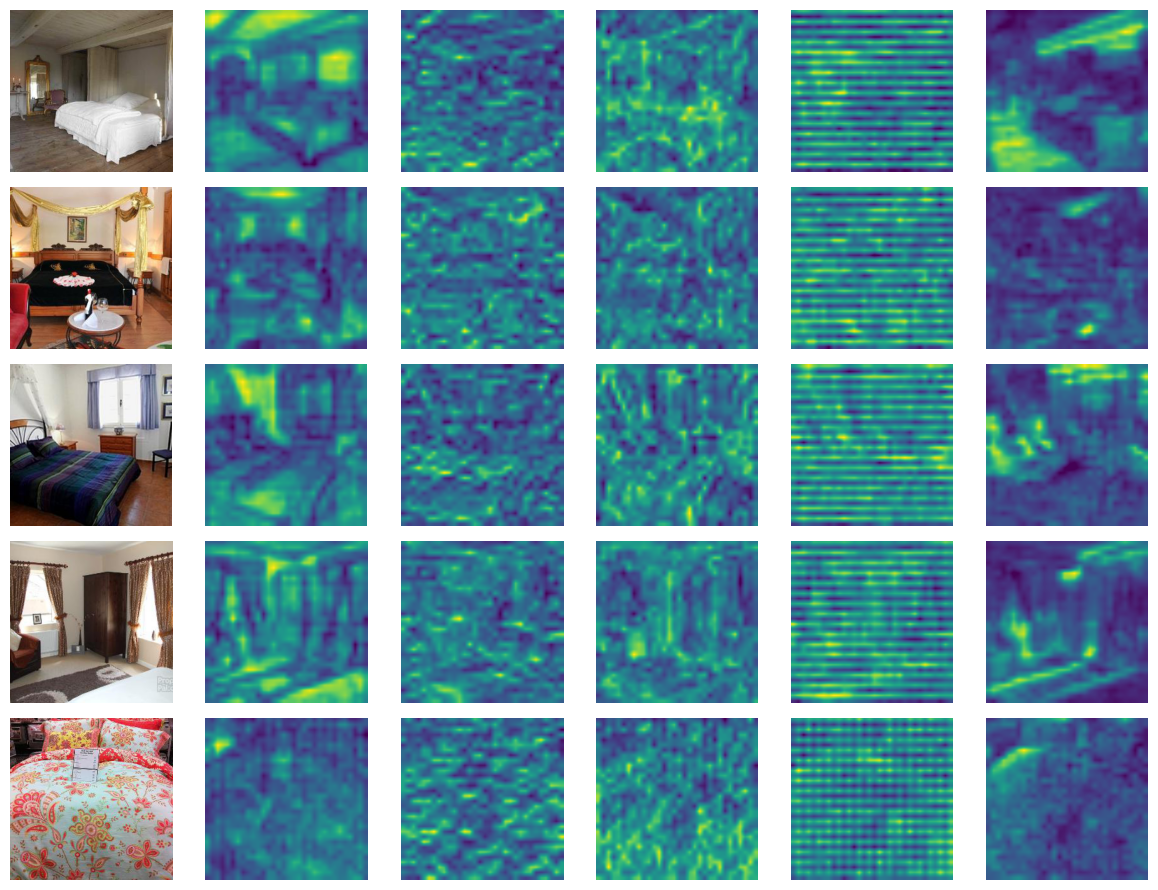

In [164]:
rows = 5
cols = 1+5

f, axs = plt.subplots(rows, cols, figsize=(2*cols,(1.8*rows)))
for row_num, sample_ in tqdm(enumerate(imgs_eval[:rows])): 
    top_neurons_idx = torch.topk(latents_list[0].permute(2,0,1).mean(dim=[1,2]), k=cols-1).indices
    img_png = sample_
    axs[row_num][0].imshow(img_png)
    for col_num, top_neuron_idx_ in enumerate(top_neurons_idx):
        img_latents_mask = latents_list[row_num].permute(2,0,1)[top_neuron_idx_]  
        axs[row_num][col_num+1].imshow(img_latents_mask)
    for ax_ in axs.flatten():
        ax_.set_axis_off()
plt.tight_layout()
plt.show()

In [147]:
latents_list[0].permute(2,0,1).shape

torch.Size([30720, 256, 256])

In [220]:
y_mask[0].shape

(256, 256)

In [242]:
y_eval 

(20, 256, 256)

In [316]:
# Let's overlap with 1 image to start with 
# Mask for the class 1
class_label = np.unique(y_eval[idx_img])[3]
y_mask = y_eval==class_label
# Take only overlap for the 0th image
idx_img = 0
latents_mask = (latents_list[idx_img].permute(2,0,1)>0)
intersection = (latents_mask * y_mask[idx_img]).sum(dim=[1,2])
sum_y_mask = y_mask[idx_img].sum(dim=[1,2])
sum_latents_mask = latents_mask.sum(dim=[1,2])

union = sum_latents_mask + sum_y_mask
iwm = intersection / sum_y_mask
iou = intersection / union

print(f"Intersection with mask\n{iwm.topk(10)}")
print(f"IoU\n{iou.topk(10)}")

Intersection with mask
torch.return_types.topk(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
indices=tensor([190, 285, 360, 207,  93, 257, 370, 415, 407,  51]))
IoU
torch.return_types.topk(
values=tensor([0.2088, 0.2084, 0.2064, 0.2064, 0.2063, 0.2062, 0.2062, 0.2061, 0.2060,
        0.2058]),
indices=tensor([  105, 16381,  6693, 19763,  2921, 13118, 11629, 25506, 21942,  6934]))


In [313]:
# print(f"Intersection with mask\n{iwm.topk(10)}\n")
# print(f"IoU\n{iou.topk(10)}")

0it [00:00, ?it/s]

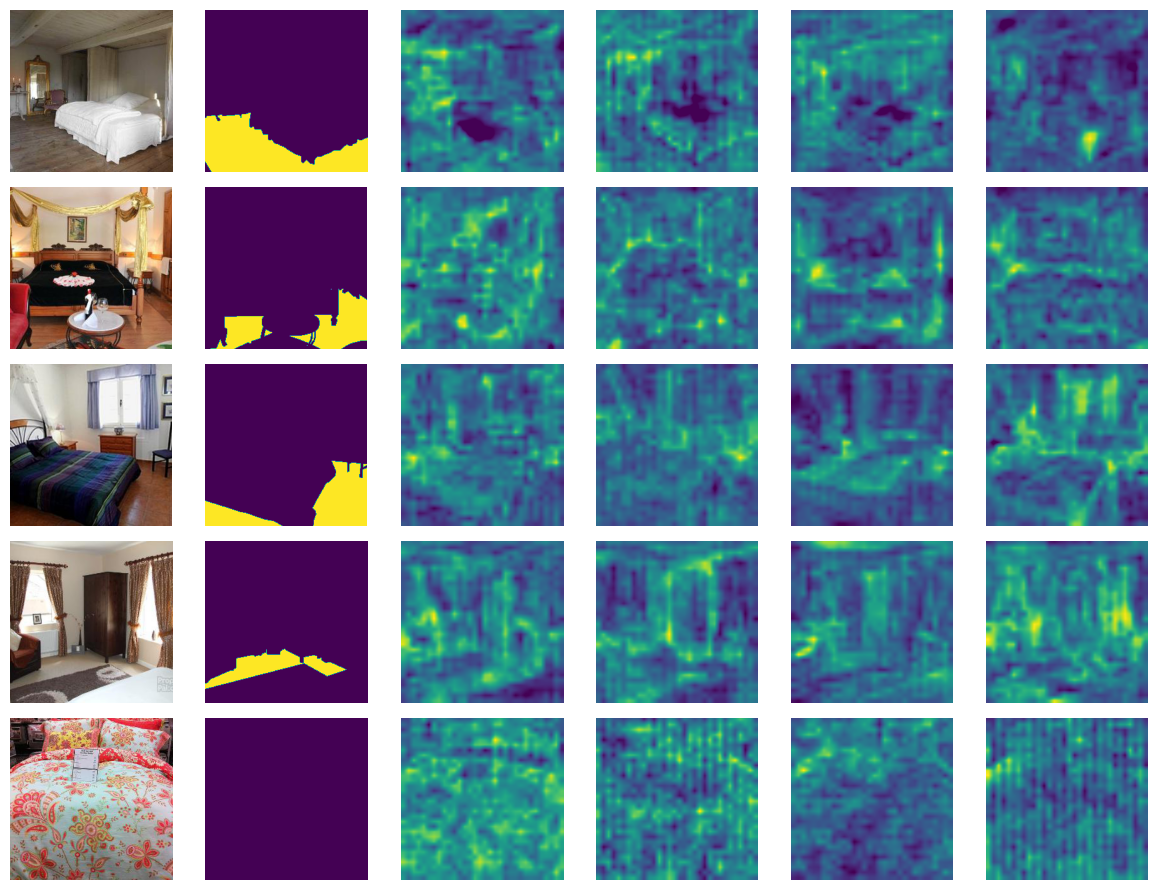

In [317]:
rows = 5
cols = 2+4

f, axs = plt.subplots(rows, cols, figsize=(2*cols,(1.8*rows)))
for row_num, sample_ in tqdm(enumerate(imgs_eval[:rows])): 
    # top_neurons_idx = torch.topk(latents_list[0].permute(2,0,1).mean(dim=[1,2]), k=cols-1).indices
    top_neurons_idx = iou.topk(4).indices
    img_png = sample_
    mask_png = y_mask[row_num]
    axs[row_num][0].imshow(img_png)
    axs[row_num][1].imshow(mask_png)
    for col_num, top_neuron_idx_ in enumerate(top_neurons_idx):
        img_latents_mask = latents_list[row_num].permute(2,0,1)[top_neuron_idx_]  
        axs[row_num][col_num+2].imshow(img_latents_mask)
    for ax_ in axs.flatten():
        ax_.set_axis_off()
plt.tight_layout()
plt.show()

In [315]:
raise NotImplementedError

NotImplementedError: 

In [174]:
torch.from_numpy(y_mask).sum(0).shape

torch.Size([256, 256])

In [214]:
y_mask_agg_by_images = torch.from_numpy(y_mask).sum(0).unsqueeze(0)
dict_top_k_neurons
# per image calculate because stacking these is too heavy
for latent_for_image_i in latents_list:
    overlap = latent_for_image_i.permute(2,0,1) * y_mask_agg_by_images
    top_overlap = torch.topk(overlap.sum(dim=[1,2]), k=2)

KeyboardInterrupt: 

In [215]:
latent_for_image_i.shape

torch.Size([256, 256, 30720])

In [218]:
256*256*30720 * 32 / 8 / 1024/1024/1024

150.0

In [212]:
latents_stack = torch.cat(latents_list)

KeyboardInterrupt: 

In [204]:
latents_list[0].permute(2,0,1).shape

torch.Size([30720, 256, 256])

In [202]:
len(latents_list)

20

In [208]:
q.shape

torch.Size([30720, 256, 256])

In [209]:
q.sum(dim=[1,2]).shape

torch.Size([30720])

In [198]:
qtop = torch.topk(q.sum(dim=[1,2]), k=2)

In [201]:
qtop

torch.return_types.topk(
values=tensor([823768.5000, 821173.6875]),
indices=tensor([10426,  1527]))

In [35]:
import gc
def cleanmem():
    for _ in range(2):
        gc.collect()
        torch.cuda.empty_cache()
cleanmem()

In [74]:
# This is too heavy
# latents_eval = torch.vstack(latents_list) # stack along the batch dim
# latents_eval.shape

In [27]:
dict_label_topklatents = {}
k = 5

for y_label in np.unique(y_eval):
    y_mask = y_eval == y_label
    1/0
    for latents_eval in tqdm(latents_list):
        latents_eval = latents_eval.permute(2,0,1)

        # print(y_mask.unsqueeze(1).shape)

        # Leave only latents that overlap with the considered label
        # latents_masked = latents_eval * y_mask.unsqueeze(1)
        latents_masked = latents_eval.unsqueeze(1) * y_mask

        # print(latents_eval)
        # print(latents_masked)

        # print(latents_masked.shape)
        acts_on_label = latents_masked.sum(0)

        # print(acts_on_label.shape)
        # plt.hist(acts_on_label, bins=100)
        # plt.semilogy()
        # plt.show()

        label_topk = acts_on_label.topk(k=5)
        dict_label_topklatents[y_label.item()] = label_topk

        # Check intersection % for top k latents
        print(f"Intersection with Mask and IoU check for label: {y_label}")
        for idx_latent in label_topk.indices:
            top_latent_activaiton_binary = latents_eval[:, idx_latent] > 0
            intersection_with_label = (y_mask * top_latent_activaiton_binary).sum() / y_mask.sum()
            iou = (y_mask * top_latent_activaiton_binary).sum() / (y_mask+top_latent_activaiton_binary).sum()
            print(f"{idx_latent:06d}| IwM:{intersection_with_label.item():.03f} | IoU:{iou.item():.03f}")    

ZeroDivisionError: division by zero

In [ ]:
dict_label_topklatents